# Predict me using Keras

- Test Sequential APIs
- Test Functional APIs
- Save and Restore model
- Using Call Backs
- Tensorboard with different hyper params
- Fine Tuning your Model
- Use the last model in the FastAPIs

In [1]:
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import warnings
import os
import cv2
import sys
import matplotlib.image as mpimg
from PIL import Image
import scipy
from scipy import ndimage
import io
import uvicorn
import numpy as np
import nest_asyncio
from enum import Enum
from fastapi import FastAPI, UploadFile, File, HTTPException
from fastapi.responses import StreamingResponse
import time
import pickle
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

# Keras APIs
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.layers.embeddings import Embedding
from keras.models import Sequential
from keras.layers import Flatten
from keras.layers import Dense
from keras import models
from tensorflow import keras
import tensorflow as tf

from configs import *
warnings.filterwarnings('ignore')
%matplotlib inline


# Build Tensor Visualization

Keras provide us with tensor vislization a helpfull tool(can be used with your web browser or even in the notebook), this tool help us see the different runs we have made and see the result of training model during each epochs.

Beside of that we need to save the best parameters on the validation set in each run, to decide which run we will use later in our APIS, to make prediction.

In [2]:

def get_run_tensor_logdir(TENSOR_DIR, run_hyper_params):
    '''
    The function used to create dierction with the time we have run the model in, beside of that,
    concat to this time which hyperparameters we have used in this run, this time along with hyperparameters, 
    will help us compare result from different run with different hyperparamters, 
    as we used the tensorboard server as our vislization tool to help decide which model we can use.
    
    Argument:
    TENSOR_DIR: the tensor logs direction to be our direction for different runs.
    run_hyper_params: which hyper params we have used for this run.
    return
    TENSOR_DIR + run id(which run along with hyperparams to create subdirectory for)
    '''
    
    run_id = time.strftime("run_%Y_%m_%d_%H_%M_%S_" + run_hyper_params)
    return os.path.join(TENSOR_DIR, run_id)

# Get Data 

100
I have 351 image of me
I have 346 image of others
Now total number of images is 697
The shape of y is:  (1, 697)
===================Before===================
(600, 30000)
(97, 30000)
(1, 600)
(1, 97)
===================After===================
(30000, 600)
(30000, 97)
(1, 600)
(1, 97)


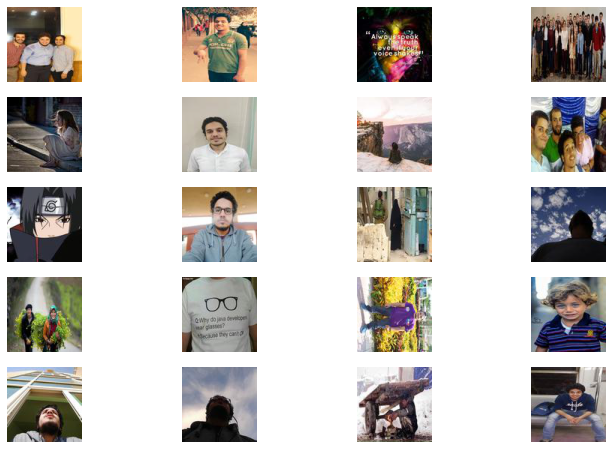

In [3]:
df_all_images = images_pipeline(100, "_100_100_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 100)

In [4]:
X_train, X_val, y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T

In [5]:
print(np.sum(y_train ==1))
print(np.sum(y_val ==1))

304
47


# Split validation set into validation and testing

In [6]:
X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size=0.3)

In [7]:
print(np.sum(y_test ==1))
print(np.sum(y_val ==1))

15
32


In [8]:
def keras_sequential_model_create(hidden_dem, active_fun):
    '''
    The function used to build your architecture of sequential model
    
    Argument:
        hidden_dem: list contain the number of neuron we need for each hidden layer
        active_fun: which activation function we need to use with the hidden layers
    
    return:
        model: The architecture of the model we have built
    '''
    
    # Create the Sequential model
    model = keras.models.Sequential()
    
    # define the shape of the input layer from the features we have for each image
    model.add(keras.layers.Input(shape=[X_train.shape[1]]))
    
    # loop over hidden layers
    for i in hidden_dem:
        # for each hidden layer pass the number of neurons for this layer
        model.add(keras.layers.Dense(i, activation=active_fun))
    
    # at the end handle the output layer as we just need to predict image belong to me or not so its just one unit
    model.add(keras.layers.Dense(1, activation='sigmoid'))
    return model

In [9]:
def keras_sequential_model_compile(model, lr):
    '''
    The architecture of the model we have built need to be compiled to define which loss function the model will use,
    beside of which optimization algorithm to update the weights to minimize the loss function. 
    other optional parameters we can pass like metrics.
    
    Argument:
        model : The model we have built
        lr    : the learning rate we need to use with the optimization algorithm (it control model step)
    return:
        model : The architecture of the model we have built and compiled 
    '''
    model.compile(loss=keras.losses.BinaryCrossentropy(), optimizer=keras.optimizers.SGD(lr=lr), metrics=['accuracy'])
    return model

In [10]:
def keras_sequential_model_fit(model, epochs, call_backs):
    '''
    The last step of model is to fit(train on the data).
    
    Argument:
        model      : The model we have built and compiled which ready to be trained.
        epochs     : the number of iterations we need to run the model for optimization. 
        call_backs : callback to help model save weights, or early stop when no progress is made and other
    '''
    history = model.fit(X_train, y_train, epochs=epochs, validation_data=(X_val, y_val),
                       callbacks=call_backs)
    return history

In [11]:
def keras_seqential_model(hidden_dem, active_fun, lr, epochs, call_backs):
    '''
    The function just used as pipeline for the sequential model.
    
    All arguments are defined in the main functions above.
    '''
    model   = keras_sequential_model_create(hidden_dem, active_fun)
    model   = keras_sequential_model_compile(model, lr)
    history = keras_sequential_model_fit(model, epochs, call_backs)
    return model, history

In [12]:
def model_hyper_params_and_run_id(img_size, api_type, hidden_dem=[300, 300, 300], active_fun='relu',
                                  lr=.02, epochs=10, patience=10):
    '''
    The function used to handle hyperparamters as we need, then call the model to be trained we these hyperparams.
    
    Argument:
        img_size: we need to know the compress of image we have made how its result with our model.
        api_type: which keras API we have used to train our model
        patience: its used for early stopping when no progress the model made, stop learning.
        
        The other arguments are defined in the main functions above.
    '''
    # define the file name with all information we need to know the effect of the hyperparameters from different runs
    learning_rate          = "_lr=" + str(lr)
    num_of_epochs          = "_epochs=" + str(epochs)
    num_of_hidden_layers   = "_num of hidden lr=" + str(len(hidden_dem))
    hyper_params_run_save_tensor  = img_size + api_type + learning_rate + num_of_epochs + num_of_hidden_layers
    
    run_log_dir = get_run_tensor_logdir(TENSOR_DIR, hyper_params_run_save_tensor)
    
    cb_early_stop   = keras.callbacks.EarlyStopping(patience=patience,monitor="val_loss",
                                                    restore_best_weights=True)
    
    cb_tensor_board = keras.callbacks.TensorBoard(run_log_dir)
    file_path      = "/run_with_" + hyper_params_run_save_tensor +  "_model.h5"
    model_save_dir = MODELS_DIR + file_path
    cb_check_point = keras.callbacks.ModelCheckpoint(model_save_dir)
    call_backs = [cb_early_stop, cb_check_point, cb_tensor_board]
    
    
    model, history = keras_seqential_model(hidden_dem, active_fun, lr, epochs, call_backs)
    return history, model_save_dir

In [ ]:
history, model_save_dir = model_hyper_params_and_run_id("img_size_100*100*3_", "sequential_api_")

In [ ]:
df_all_images = images_pipeline(300, "_300_300_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 300)

In [ ]:
X_train, X_val, y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T

In [ ]:
history, model_save_dir = model_hyper_params_and_run_id("img_size_300*300*3_", "sequential_api_")

In [ ]:
df_all_images = images_pipeline(500, "_500_500_3/")
X_train, X_val, y_train, y_val = load_train_validation_set(df_all_images)
display_some_images(X_train, 500)

500
I have 351 image of me
I have 346 image of others


In [ ]:
X_train, X_val, y_train, y_val = X_train.T, X_val.T, y_train.T, y_val.T
history, model_save_dir = model_hyper_params_and_run_id("img_size_500*500*3_", "sequential_api_")